In [1]:
import sys
import os

# Get the absolute path to the root directory where UQ_toolbox.py is located
root_dir = os.path.abspath(os.path.join(os.path.dirname('medMNIST'), '..'))
sys.path.append(root_dir)

In [2]:
import medmnist
from medmnist import INFO, Evaluator
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, ConcatDataset, random_split
import torchvision.transforms as transforms
import numpy as np
from torchvision.models import resnet18
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, roc_auc_score, accuracy_score
from sklearn.model_selection import StratifiedKFold
import seaborn as sns
import matplotlib.pyplot as plt
import UQ_toolbox as uq

In [3]:
# Define ResNet18 model
class ResNet18(nn.Module):
    def __init__(self, num_classes):
        super(ResNet18, self).__init__()
        self.model = resnet18(weights='DEFAULT')
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)
    
    def forward(self, x):
        return self.model(x)


In [4]:
# Load organAMNIST dataset
data_flag = 'organamnist'
download = True
info = INFO[data_flag]
DataClass = getattr(medmnist, info['python_class'])
num_classes = len(info['label'])
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.repeat(3, 1, 1))  # Repeat the single channel 3 times
])

test_dataset = DataClass(split='test', download=download, transform=transform)
test_loader = DataLoader(dataset=test_dataset, batch_size=128, shuffle=False)

/tmp/ipykernel_4021058/1194137215.py:20: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  ind.extend(np.array(F.softmax(torch.tensor(output.cpu().numpy()), dim=1)))


Ensemble AUC: 0.995, Ensemble Accuracy: 0.936


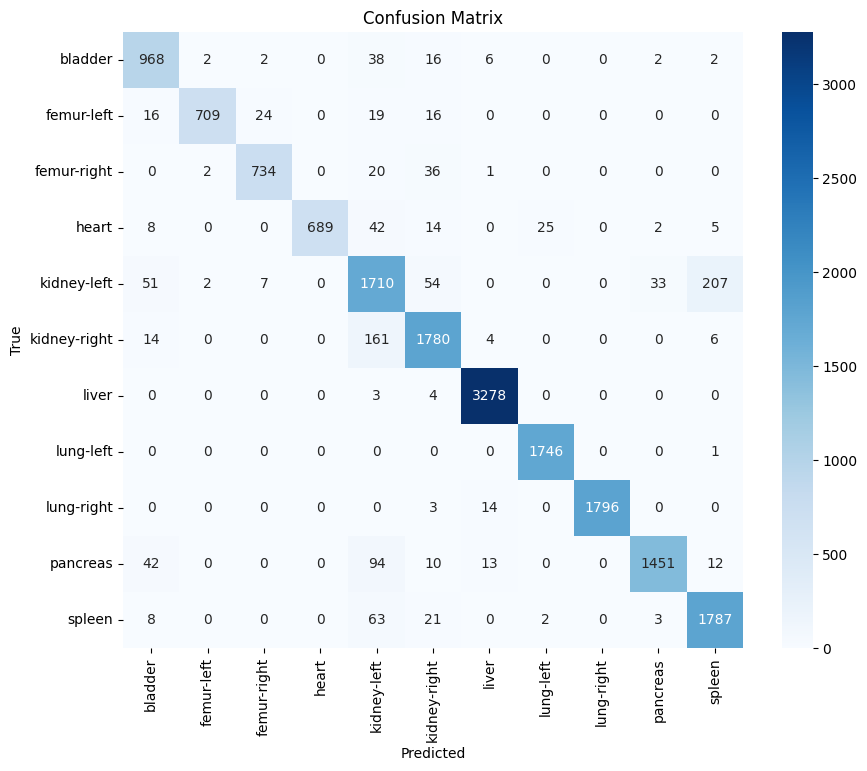

In [10]:
# Load saved models
models = []
for i in range(5):
    model = ResNet18(num_classes=num_classes)
    model.load_state_dict(torch.load(f'resnet18_organamnist{i}.pt'))
    model = model.to(device)
    model.eval()
    models.append(model)

# Perform inference on the test set
y_true = []
y_scores = []
indiv_scores = [[], [], [], [], []]

with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        outputs = [model(data) for model in models]
        for ind, output in zip(indiv_scores, outputs):
            ind.extend(np.array(F.softmax(torch.tensor(output.cpu().numpy()), dim=1)))
            
        avg_output = torch.mean(torch.stack(outputs), dim=0)
        y_true.extend(target.cpu().numpy().flatten())
        y_scores.extend(avg_output.cpu().numpy())

y_true = np.array(y_true)
y_scores = np.array(y_scores)

# Evaluate the ensemble model
evaluator = Evaluator(data_flag, 'test')
auc, acc = evaluator.evaluate(y_scores)
print(f'Ensemble AUC: {auc:.3f}, Ensemble Accuracy: {acc:.3f}')

# Generate the confusion matrix

cm = confusion_matrix(y_true, y_scores.argmax(axis=1))

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=info['label'].values(), yticklabels=info['label'].values())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [5]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.repeat(3, 1, 1))  # Repeat the single channel 3 times
])

train_dataset = DataClass(split='train', download=download, transform=transform)
val_dataset = DataClass(split='val', download=download, transform=transform)

# Combine train_dataset and val_dataset
combined_train_dataset = ConcatDataset([train_dataset, val_dataset])

# Set the random seed for reproducibility
torch.manual_seed(42)

# Calculate the sizes for training and calibration datasets
train_size = int(0.8 * len(combined_train_dataset))
calibration_size = len(combined_train_dataset) - train_size

# Split the combined_train_dataset into training and calibration datasets
train_dataset, calibration_dataset = random_split(combined_train_dataset, [train_size, calibration_size])

# Create DataLoaders for the new training and calibration datasets
calibration_loader = DataLoader(dataset=calibration_dataset, batch_size=128, shuffle=False)

print(f'Training dataset size: {len(train_dataset)}')
print(f'Calibration dataset size: {len(calibration_dataset)}')

Training dataset size: 32841
Calibration dataset size: 8211


In [ ]:
# Create stratified K-fold cross-validator
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Get the labels for stratification
labels = [label for _, label in train_dataset]

# Create a list to store the new dataloaders
train_loaders = []
val_loaders = []

for train_index, val_index in skf.split(np.zeros(len(labels)), labels):
    train_subset = torch.utils.data.Subset(train_dataset, train_index)
    val_subset = torch.utils.data.Subset(train_dataset, val_index)
    
    train_loader = DataLoader(dataset=train_subset, batch_size=128, shuffle=True, drop_last=True)
    val_loader = DataLoader(dataset=val_subset, batch_size=128, shuffle=True, drop_last=True)
    
    train_loaders.append(train_loader)
    val_loaders.append(val_loader)

/tmp/ipykernel_4021058/3139380480.py:11: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  ind.extend(np.array(F.softmax(torch.tensor(output.cpu().numpy()), dim=1)))
/tmp/ipykernel_4021058/3139380480.py:19: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  y_prob_calibration = np.array(F.softmax(torch.tensor(y_scores_calibration), dim=1))


Calibration AUC: 1.000, Calibration Accuracy: 0.998, Calibration Balanced Accuracy: 0.997


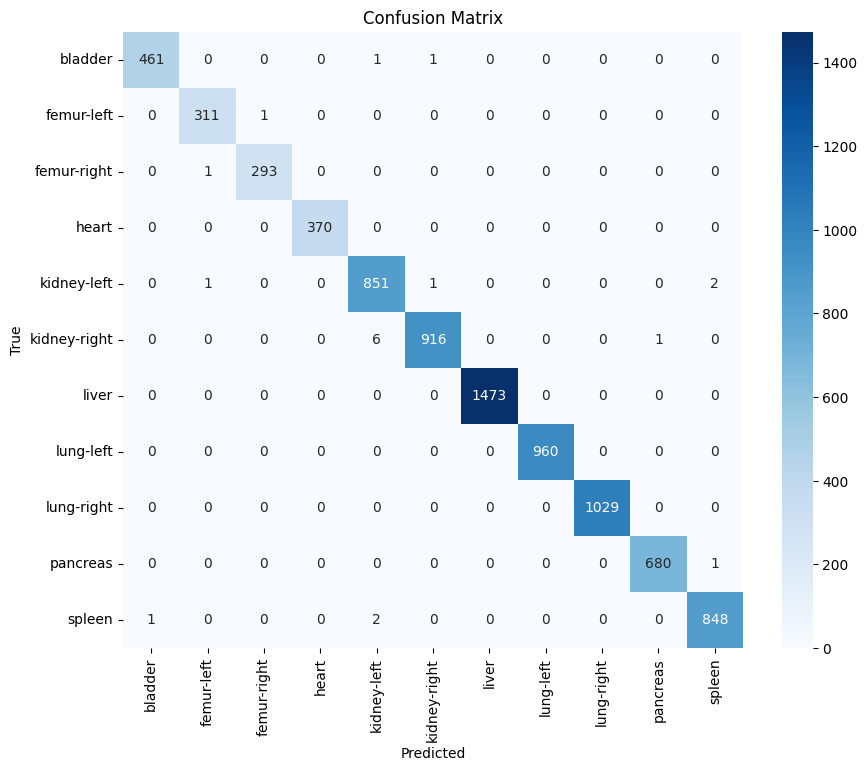

In [11]:
# Perform inference on the test set
y_true_calibration = []
y_scores_calibration = []
indiv_scores_calibration = [[], [], [], [], []]

with torch.no_grad():
    for data, target in calibration_loader:
        data, target = data.to(device), target.to(device)
        outputs = [model(data) for model in models]
        for ind, output in zip(indiv_scores_calibration, outputs):
            ind.extend(np.array(F.softmax(torch.tensor(output.cpu().numpy()), dim=1)))
            
        avg_output = torch.mean(torch.stack(outputs), dim=0)
        y_true_calibration.extend(target.cpu().numpy().flatten())
        y_scores_calibration.extend(avg_output.cpu().numpy())

y_true_calibration = np.array(y_true_calibration)
y_scores_calibration = np.array(y_scores_calibration)
y_prob_calibration = np.array(F.softmax(torch.tensor(y_scores_calibration), dim=1))
# Compute AUC, Accuracy, and Balanced Accuracy for the calibration dataset

# Compute AUC
auc_calibration = roc_auc_score(y_true_calibration, y_prob_calibration, multi_class='ovr')

# Compute Accuracy
acc_calibration = accuracy_score(y_true_calibration, y_prob_calibration.argmax(axis=1))

# Compute Balanced Accuracy
bacc_calibration = balanced_accuracy_score(y_true_calibration, y_prob_calibration.argmax(axis=1))

print(f'Calibration AUC: {auc_calibration:.3f}, Calibration Accuracy: {acc_calibration:.3f}, Calibration Balanced Accuracy: {bacc_calibration:.3f}')

# Generate the confusion matrix
cm = confusion_matrix(y_true_calibration, y_scores_calibration.argmax(axis=1))
# 
# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=info['label'].values(), yticklabels=info['label'].values())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [12]:
y_prob = np.array(F.softmax(torch.tensor(y_scores), dim=1))

/tmp/ipykernel_4021058/2939530776.py:1: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  y_prob = np.array(F.softmax(torch.tensor(y_scores), dim=1))


In [13]:
correct_predictions = [i for i in range(len(y_true)) if y_true[i] == np.argmax(y_scores[i])]
incorrect_predictions = [i for i in range(len(y_true)) if y_true[i] != np.argmax(y_scores[i])]

correct_predictions_calibration = [i for i in range(len(y_true_calibration)) if y_true_calibration[i] == np.argmax(y_scores_calibration[i])]
incorrect_predictions_calibration = [i for i in range(len(y_true_calibration)) if y_true_calibration[i] != np.argmax(y_scores_calibration[i])]

In [14]:
class ClassifierHeadWrapper(nn.Module):
    def __init__(self, model):
        super(ClassifierHeadWrapper, self).__init__()
        self.fc = model.fc  # Replace 'fc2' with the appropriate layer name

    def forward(self, x):
        return self.fc(x)

In [15]:
from torchsummary import summary

# Assuming 'model' is an instance of your ResNet18 class
model = ResNet18(num_classes=num_classes).to(device)

# Print the summary of the model
summary(model, input_size=(3, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 14, 14]           9,408
       BatchNorm2d-2           [-1, 64, 14, 14]             128
              ReLU-3           [-1, 64, 14, 14]               0
         MaxPool2d-4             [-1, 64, 7, 7]               0
            Conv2d-5             [-1, 64, 7, 7]          36,864
       BatchNorm2d-6             [-1, 64, 7, 7]             128
              ReLU-7             [-1, 64, 7, 7]               0
            Conv2d-8             [-1, 64, 7, 7]          36,864
       BatchNorm2d-9             [-1, 64, 7, 7]             128
             ReLU-10             [-1, 64, 7, 7]               0
       BasicBlock-11             [-1, 64, 7, 7]               0
           Conv2d-12             [-1, 64, 7, 7]          36,864
      BatchNorm2d-13             [-1, 64, 7, 7]             128
             ReLU-14             [-1, 6

In [16]:
print(model)

ResNet18(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runn

In [ ]:
models = [model.to(device) for model in models]
latent_spaces = []
shap_values_folds = []
success_folds = []
for fold in range(0, 5):
    print('fold n' + str(fold))
    classifier_head = ClassifierHeadWrapper(models[fold].model).to(device)
    # Compute SHAP values for the penultimate layer
    shap_values, shap_features, labels, success = uq.extract_latent_space_and_compute_shap_importance(
        model=models[fold],
        data_loader=test_loader,
        device=device,
        layer_to_be_hooked=models[fold].model.avgpool,
        classifierheadwrapper=classifier_head,
        shap_explainer='DeepExplainer',
        max_background_samples=50
    )
    latent_spaces.append(shap_features)
    shap_values_folds.append(shap_values)
    success_folds.append(success.squeeze() if success.ndim > 1 else success)

fold n0


/mnt/data/psteinmetz/archive_notebooks/Documents/UQ_toolbox.py:985: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  explainer = shap.DeepExplainer(classifier_head.to(device), torch.tensor(background_features, dtype=torch.float32, device=device))
/mnt/data/psteinmetz/archive_notebooks/Documents/UQ_toolbox.py:988: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  shap_values = explainer.shap_values(torch.tensor(features, dtype=torch.float32, device=device))


ValueError: not enough values to unpack (expected 5, got 4)

In [30]:
models = [model.to(device) for model in models]
latent_spaces = []
success_folds = []
labels_all = []
for fold in range(0, 5):
    print('fold n' + str(fold))
    # Compute SHAP values for the penultimate layer
    latent_space, labels, success, preds = uq.extract_latent_space_and_compute_shap_importance(
        model=models[fold],
        data_loader=test_loader,
        device=device,
        layer_to_be_hooked=models[fold].model.avgpool,
        importance=False
    )
    latent_spaces.append(latent_space)
    success_folds.append(success)
    labels_all.append(labels)

fold n0
fold n1
fold n2
fold n3
fold n4


In [31]:
latent_spaces_training = []
success_folds_training = []
labels_all_training = []
for fold in range(0, 5):
    print('fold n' + str(fold))
    # Compute SHAP values for the penultimate layer
    latent_space_training, labels_training, success_training, preds_training = uq.extract_latent_space_and_compute_shap_importance(
        model=models[fold],
        data_loader=train_loaders[fold],
        device=device,
        layer_to_be_hooked=models[fold].model.avgpool,
        importance=False
    )
    latent_spaces_training.append(latent_space_training)
    success_folds_training.append(success_training)
    labels_all_training.append(labels_training)

fold n0
fold n1
fold n2
fold n3
fold n4


In [32]:
success_folds[0].shape

(17778,)

In [33]:
success_folds_training[0].shape

(26240,)

In [26]:
np.unique(labels_all[0])

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [ ]:
import umap.umap_ as umap
import matplotlib.pyplot as plt

# Convert labels_all[0] to a 1D array
labels_0 = labels_all_training[0].flatten()
labels_test_0 = labels_all[0].flatten()
# Initialize UMAP
reducer = umap.UMAP(n_components=2, n_neighbors=1000, random_state=42)

# Fit and transform the latent space
embedding = reducer.fit_transform(latent_spaces_training[0].cpu().numpy())
embedding_test = reducer.transform(latent_spaces[0].cpu().numpy())

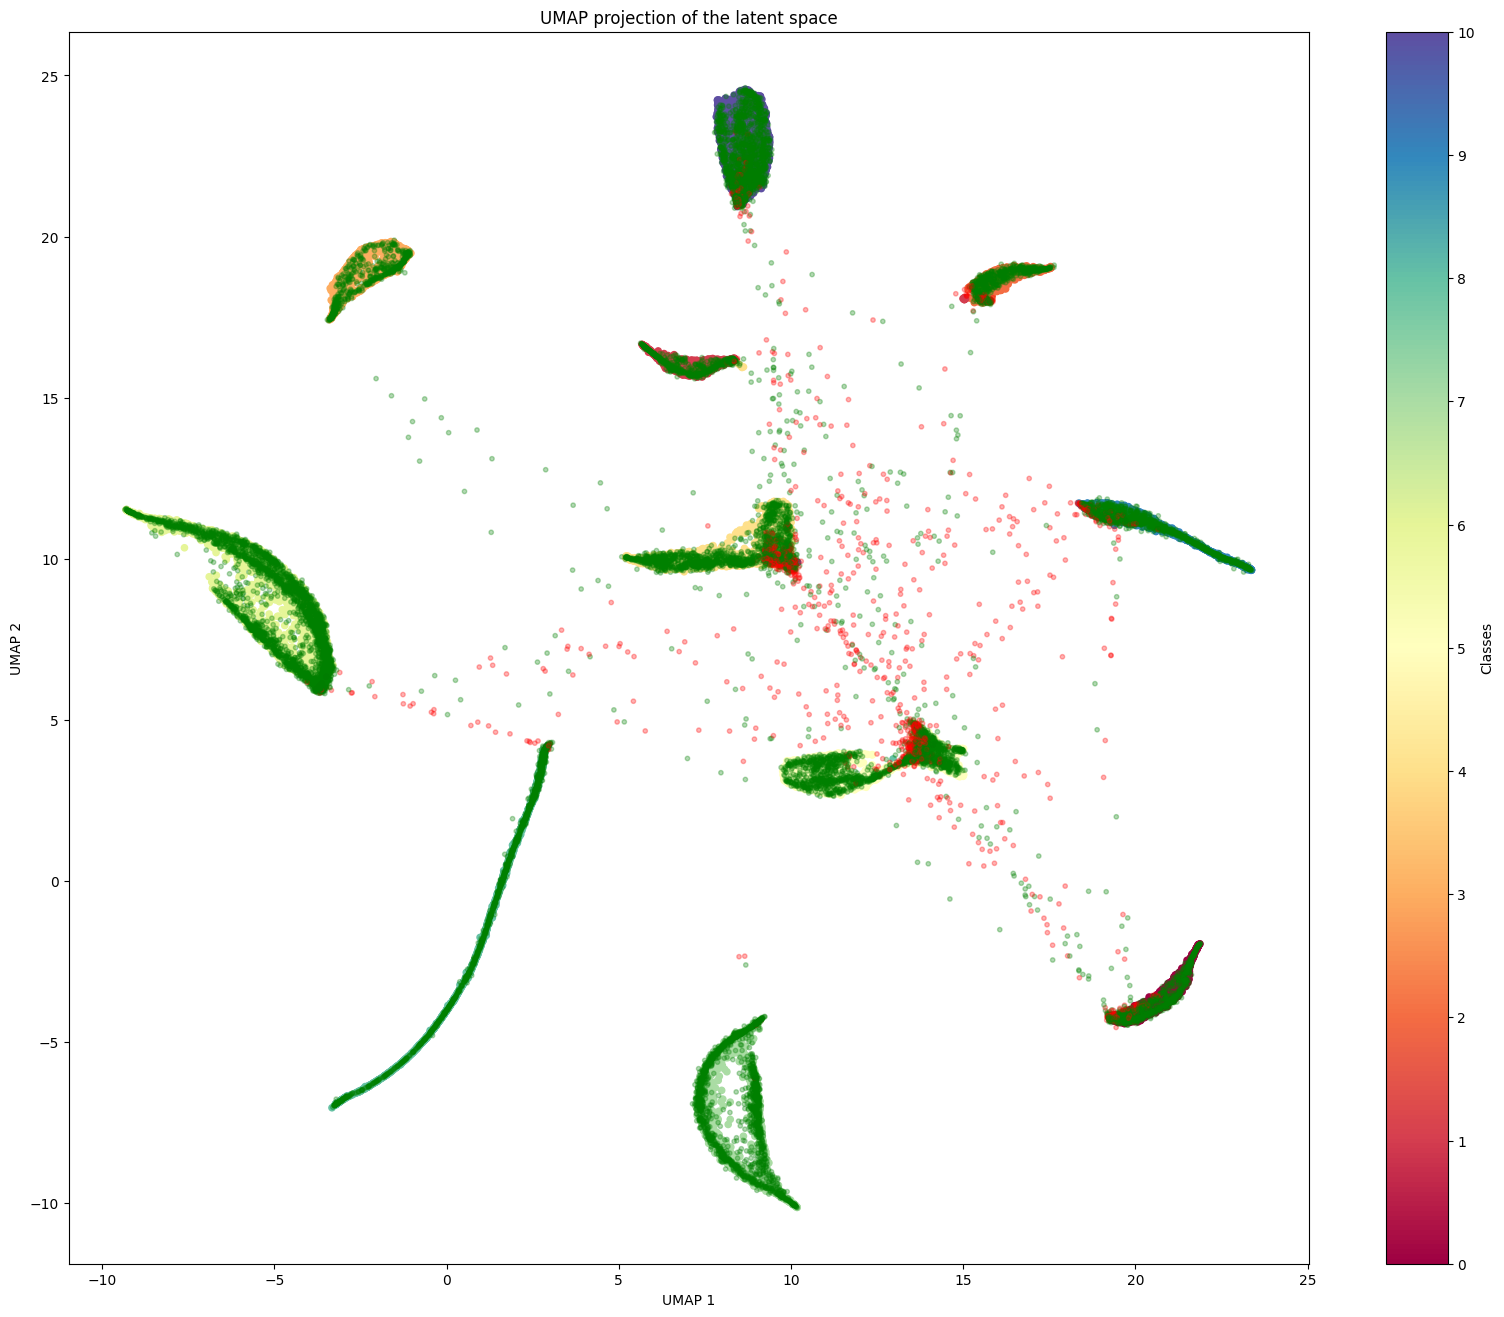

In [57]:
# Plot the UMAP embedding
plt.figure(figsize=(20, 16))
scatter = plt.scatter(embedding[:, 0], embedding[:, 1], c=labels_0, cmap='Spectral', s=20)
plt.colorbar(scatter, ticks=range(num_classes), label='Classes')

# Overlay the test data
success_colors = ['red' if success == 0 else 'green' for success in success_folds[0]]
plt.scatter(embedding_test[:, 0], embedding_test[:, 1], c=success_colors, s=10, alpha=0.3)

plt.title('UMAP projection of the latent space')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.show()

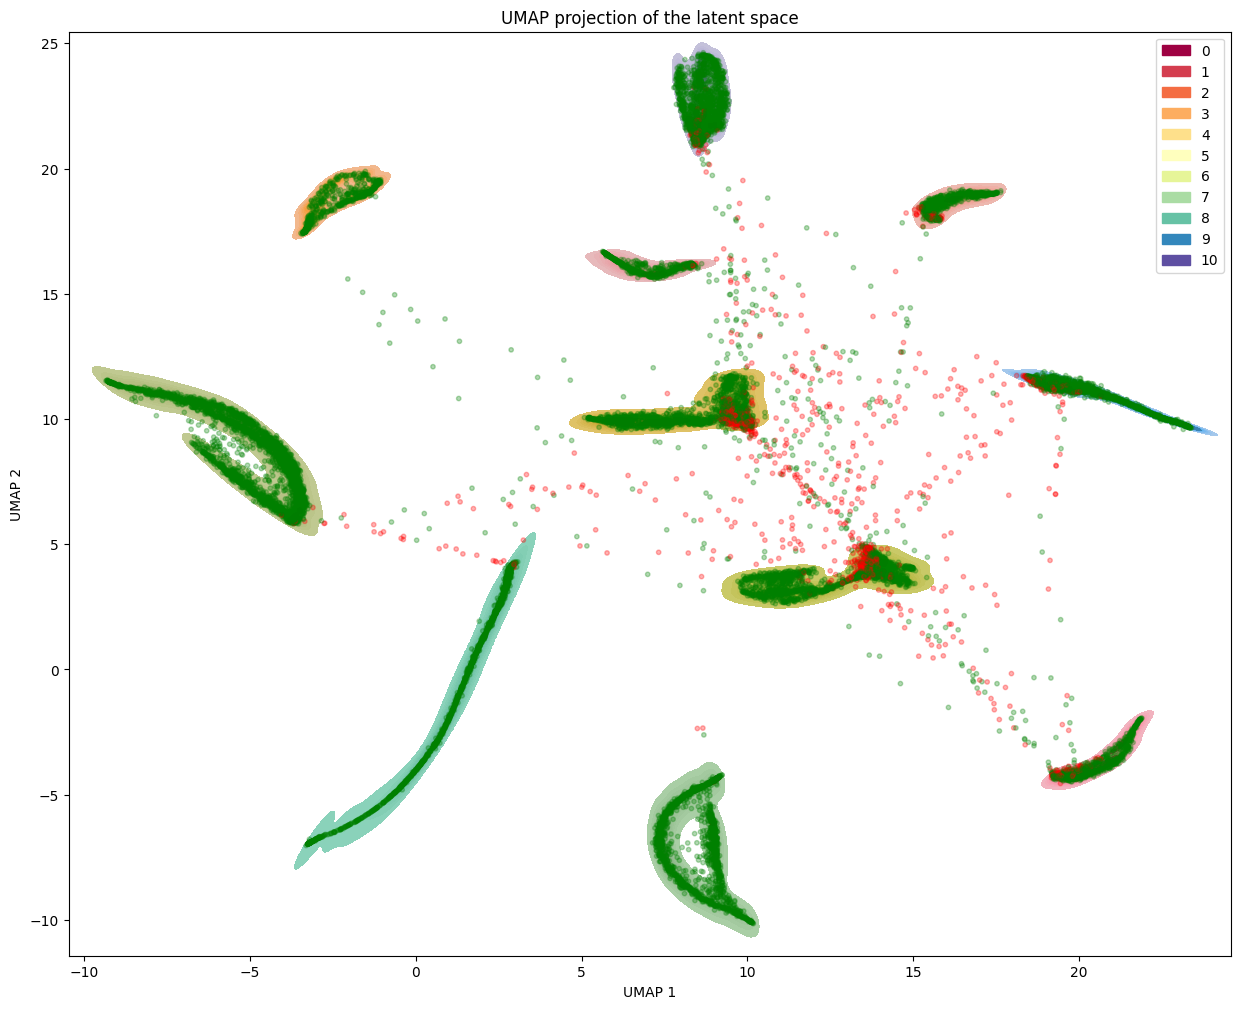

In [59]:
# Plot the UMAP embedding using KDE plot for training data
plt.figure(figsize=(15, 12))
sns.kdeplot(x=embedding[:, 0], y=embedding[:, 1], hue=labels_0, palette='Spectral', fill=True, thresh=0.05)

# Overlay the test data
success_colors = ['red' if success == 0 else 'green' for success in success_folds[0]]
plt.scatter(embedding_test[:, 0], embedding_test[:, 1], c=success_colors,  alpha=0.3, s=10)

plt.title('UMAP projection of the latent space')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.show()

In [28]:
# Check unique labels in training data
unique_labels_training = np.unique(labels_all_training[0])
print("Unique labels in training data:", unique_labels_training)

# Check unique labels in test data
unique_labels_test = np.unique(labels_all[0])
print("Unique labels in test data:", unique_labels_test)

Unique labels in training data: [ 0  1  2  3  4  5  6  7  8  9 10]
Unique labels in test data: [ 0  1  2  3  4  5  6  7  8  9 10]


In [ ]:
#uq.apply_randaugment_and_store_results(calibration_loader, models, 2, 45, 500, device, folder_name=f'savedpolicies', batch_norm=True, image_size=28, nb_channels=3, softmax_application=True)

Loading predictions...
Evaluating policy 1/30...
Evaluating policy 1/30...
Evaluating policy 1/30...
Evaluating policy 1/30...
Evaluating policy 1/30...
Selected Policy 465: roc_auc=0.9295
Evaluating policy 2/30...
Evaluating policy 1/30...
Evaluating policy 1/30...
Selected Policy 319: roc_auc=0.6678
Evaluating policy 2/30...
Evaluating policy 1/30...
Selected Policy 100: roc_auc=0.9757
Evaluating policy 2/30...
Evaluating policy 1/30...
Selected Policy 227: roc_auc=0.9743
Evaluating policy 2/30...
Evaluating policy 1/30...
Selected Policy 100: roc_auc=0.9757
Evaluating policy 2/30...
Evaluating policy 1/30...
Selected Policy 84: roc_auc=0.9573
Evaluating policy 3/30...
Selected Policy 465: roc_auc=0.9546
Evaluating policy 2/30...
Evaluating policy 1/30...
Selected Policy 112: roc_auc=0.9378
Evaluating policy 2/30...
Selected Policy 414: roc_auc=0.7143
Evaluating policy 3/30...
Evaluating policy 1/30...
Selected Policy 287: roc_auc=0.9348
Evaluating policy 2/30...
Evaluating policy 1/

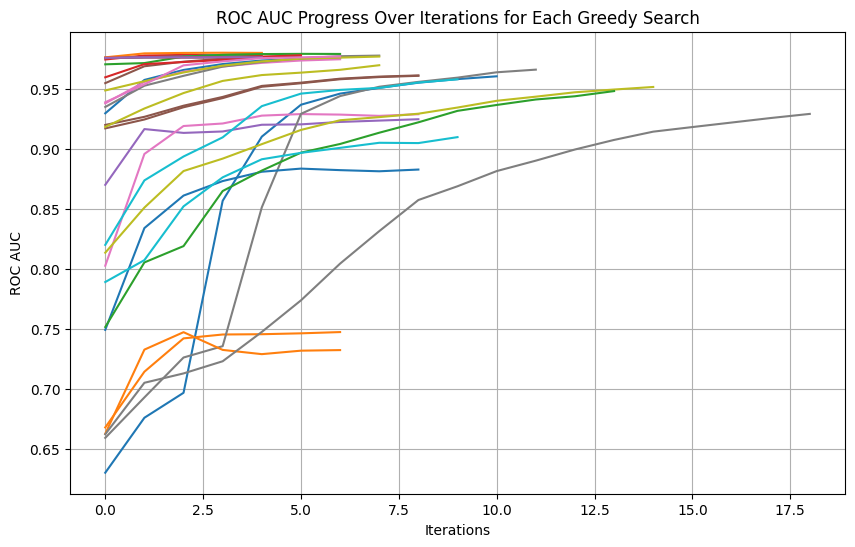

In [11]:
best_aug = uq.perform_greedy_policy_search('savedpolicies', correct_predictions_calibration, incorrect_predictions_calibration, num_workers=90, max_iterations=30, num_searches=30, top_k=5, plot=True)
n, m, transformations = uq.extract_gps_augmentations_info(best_aug)

In [15]:
stds_GPS_calibration, global_preds_GPS_calibration = uq.TTA(transformations, models, test_loader, device, usingBetterRandAugment=True, n=n, m=m, nb_channels=3, image_size=28, batch_norm=True, softmax_application=True)

Manually set transform. Current transform: 
[(11,np.float64(29.342430550380556)),(13,np.float64(18.7626608864187))]
Manually set transform. Current transform: 
[(9,np.float64(26.753347976507428)),(4,np.float64(-2.269870568517014))]
Manually set transform. Current transform: 
[(10,np.float64(1.7976877272614402)),(14,np.float64(-2.253227258808664))]
Manually set transform. Current transform: 
[(11,np.float64(-7.330877383517148)),(13,np.float64(17.226544341423256))]
Applying augmentation n : 0
Applying augmentation n : 1
Applying augmentation n : 2
Applying augmentation n : 3


/mnt/data/psteinmetz/archive_notebooks/Documents/UQ_toolbox.py:407: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Category', y=y_title, data=df, palette='muted')


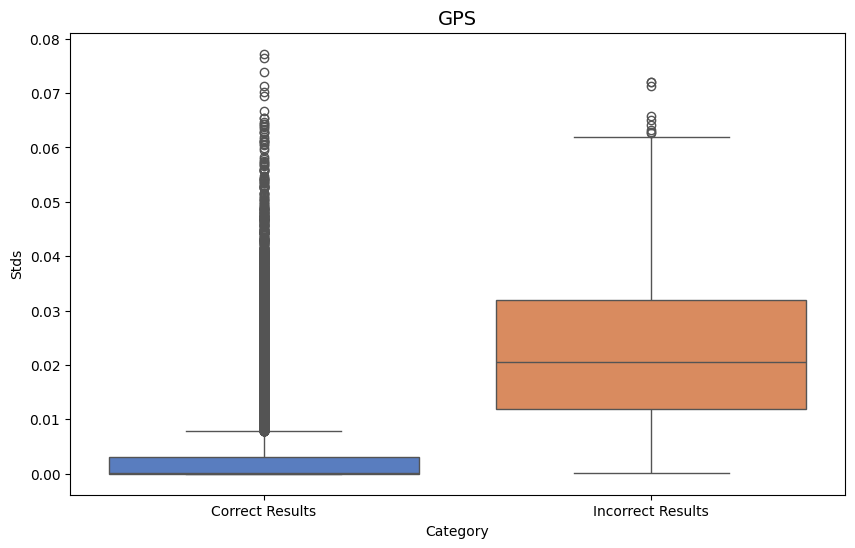

In [18]:
fpr_std_gps, tpr_std_gps, auc_std_gps = uq.roc_curve_UQ_method_computation([stds_GPS_calibration[k] for k in correct_predictions], [stds_GPS_calibration[j] for j in incorrect_predictions])
uq.UQ_method_plot([stds_GPS_calibration[k] for k in correct_predictions], [stds_GPS_calibration[j] for j in incorrect_predictions], 'Stds', 'GPS', swarmplot=False)

In [19]:
auc_std_gps

np.float64(0.9015098148864781)

In [20]:
distances = uq.distance_to_hard_labels_computation(y_prob)

/mnt/data/psteinmetz/archive_notebooks/Documents/UQ_toolbox.py:407: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Category', y=y_title, data=df, palette='muted')


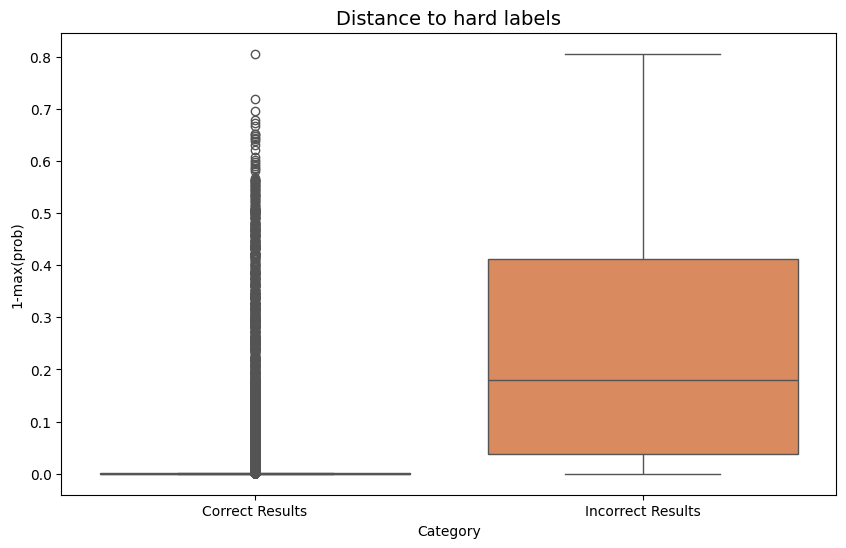

In [21]:
uq.UQ_method_plot([distances[k] for k in correct_predictions], [distances[j] for j in incorrect_predictions], '1-max(prob)', 'Distance to hard labels', swarmplot=False)

/mnt/data/psteinmetz/archive_notebooks/Documents/UQ_toolbox.py:407: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Category', y=y_title, data=df, palette='muted')


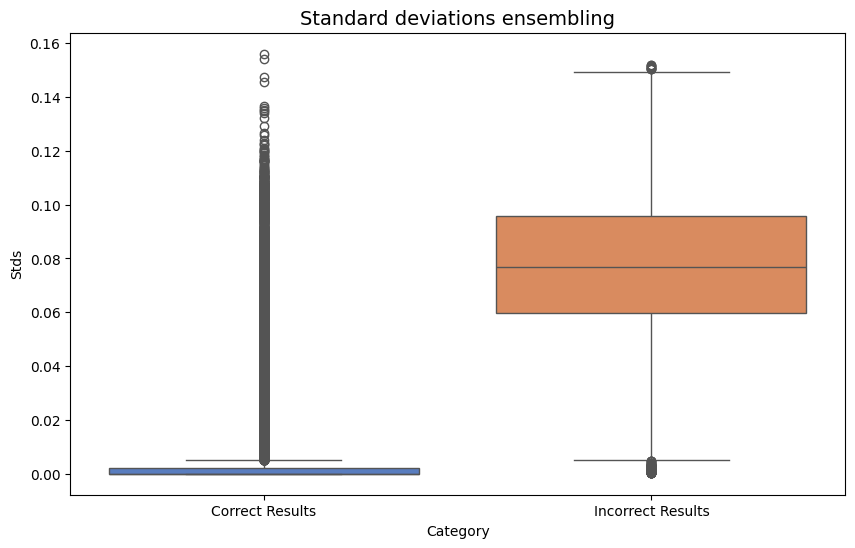

In [22]:
stds = uq.ensembling_stds_computation(indiv_scores)
uq.UQ_method_plot([stds[k] for k in correct_predictions], [stds[j] for j in incorrect_predictions], 'Stds', 'Standard deviations ensembling', swarmplot=False)

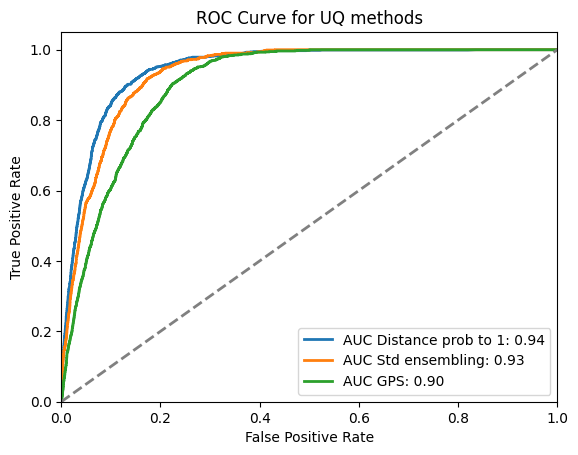

In [24]:
fpr_distance_to_hard_labels, tpr_distance_to_hard_labels, auc_distance_to_hard_labels = uq.roc_curve_UQ_method_computation([distances[k] for k in correct_predictions], [distances[j] for j in incorrect_predictions])
fpr_stds, tpr_stds, auc_stds = uq.roc_curve_UQ_method_computation([stds[k] for k in correct_predictions], [stds[j] for j in incorrect_predictions])
uq.roc_curve_UQ_methods_plot(['Distance prob to 1', 'Std ensembling', 'GPS'], [fpr_distance_to_hard_labels, fpr_stds, fpr_std_gps], [tpr_distance_to_hard_labels, tpr_stds, tpr_std_gps], [auc_distance_to_hard_labels, auc_stds, auc_std_gps])

In [25]:
mean_values = uq.standardize_and_mean_ensembling(np.column_stack((stds, distances, stds_GPS_calibration)))

In [28]:
mean_values_noGPS = uq.standardize_and_mean_ensembling(np.column_stack((stds, distances)))

/mnt/data/psteinmetz/archive_notebooks/Documents/UQ_toolbox.py:407: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Category', y=y_title, data=df, palette='muted')


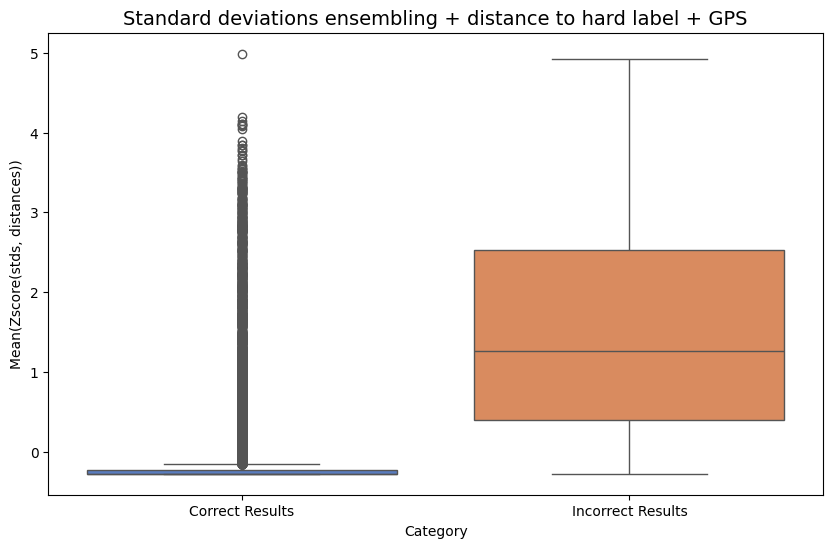

In [26]:
uq.UQ_method_plot([mean_values[k] for k in correct_predictions], [mean_values[j] for j in incorrect_predictions], 'Mean(Zscore(stds, distances))', 'Standard deviations ensembling + distance to hard label + GPS', swarmplot=False)

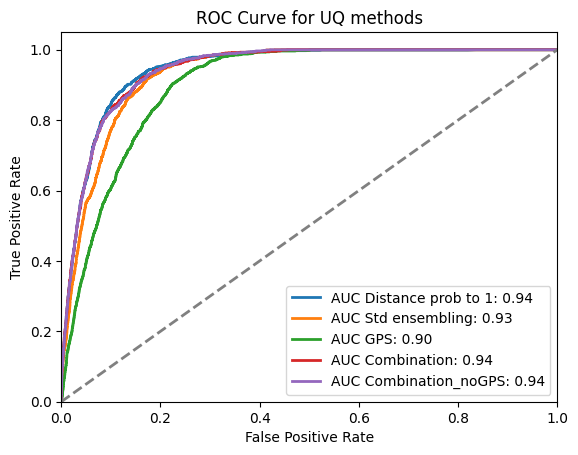

In [29]:
fpr_comb, tpr_comb, auc_comb = uq.roc_curve_UQ_method_computation([mean_values[k] for k in correct_predictions], [mean_values[j] for j in incorrect_predictions])
fpr_comb_noGPS, tpr_comb_noGPS, auc_comb_noGPS = uq.roc_curve_UQ_method_computation([mean_values_noGPS[k] for k in correct_predictions], [mean_values_noGPS[j] for j in incorrect_predictions])
uq.roc_curve_UQ_methods_plot(['Distance prob to 1', 'Std ensembling', 'GPS', 'Combination', 'Combination_noGPS'], [fpr_distance_to_hard_labels, fpr_stds, fpr_std_gps, fpr_comb, fpr_comb_noGPS], [tpr_distance_to_hard_labels, tpr_stds, tpr_std_gps, tpr_comb, tpr_comb_noGPS], [auc_distance_to_hard_labels, auc_stds, auc_std_gps, auc_comb, auc_comb_noGPS])

In [ ]:
import pandas as pd
from sklearn.metrics import confusion_matrix, balanced_accuracy_score
import itertools

# Define the metrics
metrics = {
    "Dist to HL": distances,
    "Std": stds
}

# Define the labels
labels = np.array([1 if i in correct_predictions else 0 for i in range(len(mean_values))])

# Function to compute metrics
def compute_metrics(uq_values, labels, threshold):
    predictions = (uq_values <= threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(labels, predictions).ravel()
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    balanced_acc = balanced_accuracy_score(labels, predictions)
    return tn, fp, fn, tp, specificity, sensitivity, balanced_acc

# Function to find the optimal threshold
def find_optimal_threshold(uq_values, labels, max_fp_rate=0.001):
    thresholds = np.linspace(min(uq_values), max(uq_values), 1000)
    best_threshold = thresholds[0]
    best_tp = 0
    total_cases = len(labels)
    max_fp = total_cases * max_fp_rate
    for threshold in thresholds:
        tn, fp, fn, tp, specificity, sensitivity, balanced_acc = compute_metrics(uq_values, labels, threshold)
        if fp <= max_fp and tp > best_tp:
            best_tp = tp
            best_threshold = threshold
    return best_threshold

# Function to summarize results
def summarize_results(uq_values, labels, threshold):
    tn, fp, fn, tp, specificity, sensitivity, balanced_acc = compute_metrics(uq_values, labels, threshold)
    total_cases = len(labels)
    tp_proportion = tp / total_cases
    fp_proportion = fp / total_cases
    return tp, tp_proportion, fp, fp_proportion

def display_confusion_matrix_success_flags_prop(cm):
    # Convert cm to a Pandas DataFrame
    df_cm = pd.DataFrame(cm, index=['Failures', 'Success'], columns=['Failures', 'Success'])

    # Convert to proportions (normalize by total sum)
    cm_proportions = (cm.astype(np.float64) / cm.sum()) * 100  # Convert to percentage
    cm_proportions = pd.DataFrame(cm_proportions, index=df_cm.index, columns=df_cm.columns)  # Convert to DataFrame

    # Initialize annotations with the same shape as df_cm
    annotations = df_cm.copy().astype(str)

    # Add percentage values to the confusion matrix
    for i in range(df_cm.shape[0]):
        for j in range(df_cm.shape[1]):
            annotations.iloc[i, j] = f"{df_cm.iloc[i, j]} ({cm_proportions.iloc[i, j]:.1f}%)"

    # Plot the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(df_cm, annot=annotations, fmt='', cmap='Blues', cbar=False, annot_kws={"size": 30})
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()
    
# Define a function to display the confusion matrix and metrics
def display_results(uq_values, labels, threshold):
    tn, fp, fn, tp, specificity, sensitivity, balanced_acc = compute_metrics(uq_values, labels, threshold)
    cm = confusion_matrix(labels, (uq_values <= threshold).astype(int))
    display_confusion_matrix_success_flags_prop(cm)
    print(f"Threshold: {threshold}")
    print(f"Specificity (TNR): {specificity:.2f}")
    print(f"Sensitivity (TPR): {sensitivity:.2f}")
    print(f"Balanced Accuracy: {balanced_acc:.2f}")
    print(f"True Negatives (TN): {tn}")
    print(f"False Positives (FP): {fp}")
    print(f"False Negatives (FN): {fn}")
    print(f"True Positives (TP): {tp}")

# Create a DataFrame to store the results
results = []

# Perform ablation study for each metric separately
for metric_name, uq_values in metrics.items():
    best_threshold = find_optimal_threshold(uq_values, labels)
    tp, tp_proportion, fp, fp_proportion = summarize_results(uq_values, labels, best_threshold)
    results.append([metric_name, f"{tp} ({tp_proportion:.2%})", f"{fp} ({fp_proportion:.2%})"])
    display_results(uq_values, labels, best_threshold)

# Perform ablation study for combinations of metrics
for r in range(2, len(metrics) + 1):
    for combination in itertools.combinations(metrics.keys(), r):
        combined_uq_values = uq.standardize_and_mean_ensembling(np.column_stack([metrics[key] for key in combination]))
        best_threshold = find_optimal_threshold(combined_uq_values, labels)
        tp, tp_proportion, fp, fp_proportion = summarize_results(combined_uq_values, labels, best_threshold)
        results.append([", ".join(combination), f"{tp} ({tp_proportion:.2%})", f"{fp} ({fp_proportion:.2%})"])
        display_results(combined_uq_values, labels, best_threshold)

# Convert results to DataFrame
results_df = pd.DataFrame(results, columns=["Metric(s)", "TP (Count, Proportion)", "FP (Count, Proportion)"])

# Display the results
print(results_df)